In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values.astype('float64')  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values.astype('float64')
    train_ua = train['ua'][:, :12].values.astype('float64')
    train_va = train['va'][:, :12].values.astype('float64')
    train_label = label['nino'][:, 12:36].values.astype('float64')

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values.astype('float64')  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values.astype('float64')
    train_ua2 = train2['ua'][:, :12].values.astype('float64')
    train_va2 = train2['va'][:, :12].values.astype('float64')
    train_label2 = label2['nino'][:, 12:36].values.astype('float64')
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    dict_cmip = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_soda = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [90, 10])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2 + train_2 
    valid_dataset = valid_2 + valid_1 + valid_2 + valid_2 + valid_2 + valid_2
    
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.tight_layout()
        plt.show()
        

In [45]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
        self.lstm = nn.LSTM(input_size = 5460, hidden_size = 64, num_layers=2, batch_first=True, bidirectional=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 128))
        self.linear = nn.Linear(128, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.conv1(sst)  # batch * 12 * (24 - 3) * (72 -7)
        t300 = self.conv2(t300)
        ua = self.conv3(ua)
        va = self.conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
        x = self.batch_norm(x)
        x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
        x = self.avgpool(x).squeeze(-2)
        x = self.linear(x)
        return x

In [46]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [47]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 2.950240M


In [48]:
model

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (batch_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(5460, 64, num_layers=2, batch_first=True, bidirectional=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 128))
  (linear): Linear(in_features=128, out_features=24, bias=True)
)

acskill_socre:4.475203316193081, rmse_score:19.51344954880807
Epoch: 0, Valid Score: -15.038246232614988

Step: 0, Train Loss: 0.8649952411651611
Step: 20, Train Loss: 0.6777200698852539
Step: 40, Train Loss: 0.6641476154327393
Step: 60, Train Loss: 0.626501202583313
Step: 80, Train Loss: 0.7677274942398071
Step: 100, Train Loss: 0.7257859110832214
Step: 120, Train Loss: 0.4269285202026367
Step: 140, Train Loss: 0.8222362399101257
Epoch: 1, Train loss: 0.6863247154244951
acskill_socre:44.86699442538098, rmse_score:17.661481022616968
Epoch: 1, Valid Score: 27.205513402764012
Model saved successfully


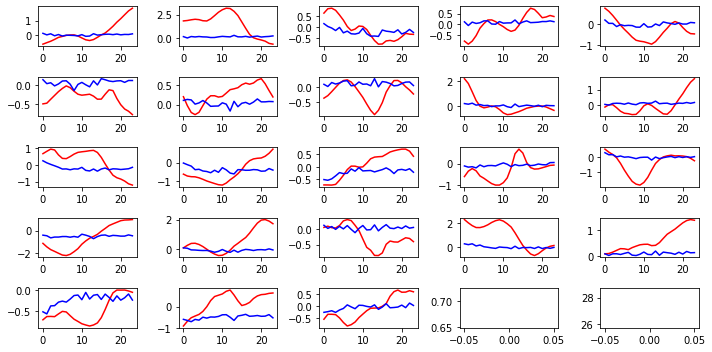

Step: 0, Train Loss: 0.4212909936904907


In [ ]:
train(num_epochs=80)

In [ ]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [ ]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [ ]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [ ]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [ ]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [ ]:
make_zip()